# Functions to preprocess data
Requires a pandas dataframe as input
Provides a pandas dataframe as output

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns

directory = os.getcwd()
data_path = os.path.join(directory, "data")

artists_file = os.path.join(data_path, "artists.dat")
artists_spotify_file = os.path.join(data_path, "data_by_artist_o.csv")
users_artists_file = os.path.join(data_path, "user_artists.dat")

#import data
artist_sp_df = pd.read_csv(artists_spotify_file)
print("artist_sp_df shape: ",artist_sp_df.shape)

artist_df = pd.read_csv(artists_file,sep="\t")
print("artist_df shape: ",artist_df.shape)

weights_df = pd.read_csv(users_artists_file,sep="\t")
print("weights_df shape: ",weights_df.shape)



artist_sp_df shape:  (28680, 16)
artist_df shape:  (17632, 4)
weights_df shape:  (92834, 3)


In [2]:
#remove weights outside of thresholds 
#Avoids issues with uncommon listening habits. 
#i.e: users that have played artist over 100k times
def remove_extreme_weights (df,min_weight,max_weight):
    '''
    Requires input dataframe with userID, artistID, weight columns
    min_weight = min # times a user must have played an aritst to keep the record
    max_weight = max # times a user must have played an aritst to keep the record
    '''    
    print('\n')
    print('**Remove Extreme (hig,low) Weights**')
    print('df original shape: ',df.shape)    
    sns.boxplot(y="weight", data=df)
    plt.title('Boxplot - Original Data')
    plt.show()
    
    bin_data = df.copy()
    labels = ['a.<10','b.10-1K','c.1K-5K','d.5K-10K','e.10K-20K','f.20K-50K','g.50K-100K','h.+100K']
    bins = [0, 10,1000,5000,10000,20000,50000,100000, np.inf]
    bin_data['weight_bin'] = pd.cut(bin_data['weight'], bins,labels=labels)
    print('original data binned:')
    print(bin_data['weight_bin'].value_counts(sort=False))
    print('\n')

    filtered_df = df[df['weight'].between(min_weight, max_weight)].reset_index(drop=True)
    print('df new shape: ',filtered_df.shape)
    sns.boxplot(y="weight", data=filtered_df)
    plt.title('Boxplot - Filtered Data')
    plt.show()
    print('filtered data - stats:')
    print(filtered_df['weight'].describe())
    print('\n')
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")
    
    return filtered_df



**Remove Extreme (hig,low) Weights**
df original shape:  (92834, 3)


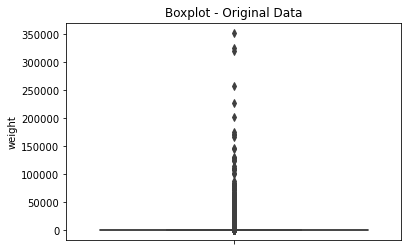

original data binned:
a.<10          3461
b.10-1K       75313
c.1K-5K       12509
d.5K-10K        921
e.10K-20K       380
f.20K-50K       188
g.50K-100K       37
h.+100K          25
Name: weight_bin, dtype: int64


df new shape:  (89545, 3)


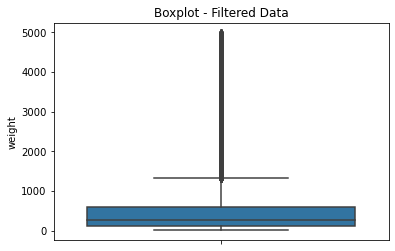

filtered data - stats:
count    89545.000000
mean       509.468792
std        696.317684
min          5.000000
25%        112.000000
50%        260.000000
75%        594.000000
max       4991.000000
Name: weight, dtype: float64


% of removed records: 0.0354


In [3]:
weights_filtered = remove_extreme_weights(weights_df,5,5000)

In [4]:
#source: https://github.com/statisticianinstilettos/recmetrics/blob/master/recmetrics/plots.py 

from matplotlib.lines import Line2D
def long_tail_plot(df, item_id_column, percentage=0.75):
    """
    Plots the long tail for a user-item interaction dataset.
    ----------
    df: pandas dataframe
        user-item interaction dataframe
        example:
    item_id_column: str
        column name identifying the item ids in the dataframe
    percentage: float, default=None
        percent of volume to consider as the head (percent as a decimal)
        (if default=None no line will be plotted)

    Returns:
    -------
        A long tail plot
    """
    volume_df = df[item_id_column].value_counts().reset_index()
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()
    
    #line plot of cumulative volume
    ax=sns.lineplot(x = 'index', y="volume", data=volume_df.reset_index(), color="black")
    #set labels
    ax.set_title('Long Tail Plot of User weights by Artist')
    ax.set_ylabel('# of user weights')
    ax.set_xlabel(item_id_column)
    plt.tick_params(labelbottom = False)
    
    #plot vertical line at the tail location
    head = volume_df[volume_df["percent_of_total_volume"] <= percentage]
    tail = volume_df[volume_df["percent_of_total_volume"] > percentage]
    items_in_head = len(head)
    items_in_tail = len(tail)
    plt.axvline(x=items_in_head, color="red",  linestyle='--')

    # fill area under plot
    head = head.append(tail.head(1))
    x1 = head.index.values
    y1 = head['volume']
    x2 = tail.index.values
    y2 = tail['volume']
    ax.fill_between(x1, y1, color="blue", alpha=0.2)
    ax.fill_between(x2, y2,  color="orange", alpha=0.2)

    #create legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': artists in the head', markerfacecolor='blue', markersize=5),
                       Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': artists in the tail', markerfacecolor='orange', markersize=5)]
    ax.legend(handles=legend_elements, loc=1)

    plt.show()

In [5]:
def remove_popular_artists(df,artist_df,pct_remove):
    '''
    Requires input dataframe with [userID, artistID, weight] columns
    Requires lastfm artist input dataframe with [id, name] columns
    pct_remove: pct of top artists to remove. Example: 0.01 removes the top 1% artists with
    top count of users (popular)
    Dont filter if your algorithm will already take care of this artist-level bias
    '''  
    print('\n')
    print('**Remove Highly Popular Artists**')
    #input dataset info
    print(f"input data shape: {df.shape}")
    print('unique artists: ',df['artistID'].nunique())

    artists_group = df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)

    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of tot Users per Artist')
    #plt.ylabel('count of users')
    #plt.show()
    pct_plot = 0.8
    print(f"line divides top: {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(df,'artistID',0.8)
    
    top_list = artists_group.head(10).index
    print('top 10 artists (most users): ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    print('\n')

    #filter dataset
    threshold = artists_group['count'].quantile(1-pct_remove) #percentile
    removed_artists = artists_group[artists_group['count'] > threshold].index
    filtered_df = df[~df['artistID'].isin(removed_artists)].reset_index(drop=True)
    num_removed = len(removed_artists)
    print(f"total removed artists: {num_removed}") 

    #new dataset info
    artists_group = filtered_df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Distribution of tot Users per Artist - Filtered Dataset')
    #plt.ylabel('count of users')
    #plt.show()
    print('\n')
    print(f"line divides top: {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(filtered_df,'artistID',pct_plot)
    
    top_list = artists_group.head(10).index
    print('top 10 artists (most users) - filtered dataset: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    
    print('\n')
    print(f"filtered dataset shape: {filtered_df.shape}") 
    print('unique artists after removal: ',filtered_df['artistID'].nunique())
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")


    return filtered_df

In [6]:
#weights_filtered = remove_popular_artists(weights_for_model,artist_df,0.01)

In [7]:
def remove_rare_artists(df,artist_df,min_users):
    '''
    Requires input dataframe with [userID, artistID, weight] columns
    Requires lastfm artist input dataframe with [id, name] columns
    min_users: minimum number of users each artist must have 
    Dont filter if your algorithm will already take care of this artist-level bias
    '''  
    print('\n')
    print('**Remove Rare Artists**')
    #input dataset info
    print(f"input data shape: {df.shape}")
    print('unique artists: ',df['artistID'].nunique())

    artists_group = df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    pct_plot = 0.8
    print(f"line divides top: {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(df,'artistID',0.8)
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of User count by Artist')
    #plt.ylabel('count of users')
    #plt.show()
    
    top_list = artists_group.tail(10).index
    print('bottom 10 artists: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    print('\n')

    #filter dataset
    #threshold = artists_group['count'].quantile(pct_remove) #percentile
    removed_artists = artists_group[artists_group['count'] < min_users].index
    filtered_df = df[~df['artistID'].isin(removed_artists)].reset_index(drop=True)
    num_removed = len(removed_artists)
    print(f"total removed artists: {num_removed}") 

    #new dataset info
    artists_group = filtered_df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of User count by Artist')
    #plt.ylabel('count of users')
    #plt.show()
    print('\n')
    print(f"line divides top: {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(filtered_df,'artistID',0.8)
    
    top_list = artists_group.tail(10).index
    print('bottom 10 artists - filtered dataset: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    
    print('\n')
    print(f"filtered dataset shape: {filtered_df.shape}") 
    print('unique artists after removal: ',filtered_df['artistID'].nunique())
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")


    return filtered_df



**Remove Rare Artists**
input data shape: (89545, 3)
unique artists:  17151
line divides top: 80.0 % cumulative sum of users:


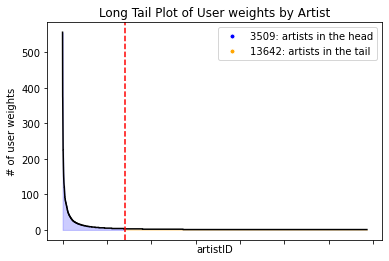

bottom 10 artists: 
9094             Myrmidon Process
9095                The Hannibals
9096             The Pinker Tones
9098     Great Lakes Myth Society
9103                  Saxon Shore
9107                    Lynch Mob
9108                Marconi Union
9116                 Paul Rodgers
9122                        Alpha
17631            Grzegorz Tomczak
Name: name, dtype: object


total removed artists: 15102


line divides top: 80.0 % cumulative sum of users:


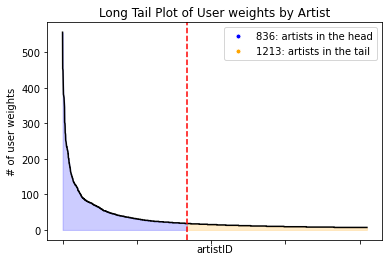

bottom 10 artists - filtered dataset: 
2539           Kajagoogoo
2549                 Styx
2564           Rogue Wave
2578            will.i.am
2605     Barenaked Ladies
5353      Blue Foundation
5358            Frou Frou
5365       Kasia Kowalska
5411        Alexis Jordan
12802            Don Omar
Name: name, dtype: object


filtered dataset shape: (64832, 3)
unique artists after removal:  2049
% of removed records: 0.276


In [8]:
weights_filtered_rare = remove_rare_artists(weights_filtered,artist_df,7)

In [9]:
#remove users with low artist count. 
#Avoid issues if user only listens to 1 artist
def remove_users_lowcount (df,min_artists):
    '''
    Requires input dataframe with userID, artistID, weight columns
    min_artists = minimum number of artists a user must have listened to
    '''    
    print('\n')
    print('**Remove User with lowcount of samples (artists)**')
    print('df original shape: ',df.shape)
    print('unique users: ',df['userID'].nunique())

    grouped_df = df.groupby('userID', dropna=False).agg({'artistID':['count']})
    grouped_df = grouped_df.droplevel(axis=1, level=0)
    users_drop = grouped_df[grouped_df['count'] < min_artists].index

    print(f"users with less than {min_artists} artists: {len(users_drop)}")

    new_df = df[~df['userID'].isin(users_drop)].reset_index(drop=True)

    print('unique users after removal: ',new_df['userID'].nunique())
    print('df new shape: ',new_df.shape)
    print(f"% of removed records: {round(1-(new_df.shape[0]/df.shape[0]),4)}")
    return new_df


In [10]:
weights_for_model = remove_users_lowcount(weights_filtered_rare,10)



**Remove User with lowcount of samples (artists)**
df original shape:  (64832, 3)
unique users:  1855
users with less than 10 artists: 66
unique users after removal:  1789
df new shape:  (64471, 3)
% of removed records: 0.0056




**Remove Highly Popular Artists**
input data shape: (64471, 3)
unique artists:  2049
line divides top: 80.0 % cumulative sum of users:


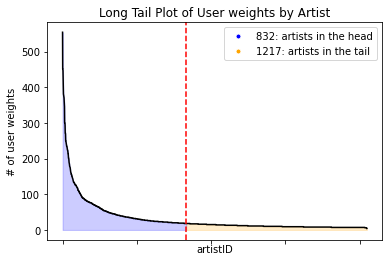

top 10 artists (most users): 
61            Madonna
83          Lady Gaga
148         Radiohead
184              Muse
221       The Beatles
282           Rihanna
283    Britney Spears
294        Katy Perry
327     Avril Lavigne
492          Paramore
Name: name, dtype: object


total removed artists: 21


line divides top: 80.0 % cumulative sum of users:


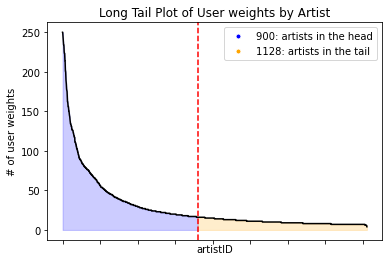

top 10 artists (most users) - filtered dataset: 
66        Depeche Mode
151    Michael Jackson
157         Pink Floyd
167            Placebo
201     Arctic Monkeys
222      Kings of Leon
228            Nirvana
285     Kelly Clarkson
292         Lily Allen
673          Glee Cast
Name: name, dtype: object


filtered dataset shape: (56810, 3)
unique artists after removal:  2028
% of removed records: 0.1188


In [11]:
weights_filtered = remove_popular_artists(weights_for_model,artist_df,0.01)

In [12]:
#scale weights at user level
#2 users might have a favorite artist, user 1 played such artist 100k times
#user 2 played such artist 10k times. However those users are still neighbors
#dont scale if your algorithm will already take care of this user-level bias

def scale_weight_by_user(df):
    '''
    Requires input dataframe with userID, artistID, weight columns
    Dont scale if your algorithm will already take care of this user-level bias
    '''  
    print('\n')
    print('**Scaling**')
    print('df original shape: ',df.shape)    
    sns.boxplot(y="weight", data=df)
    plt.title('Boxplot - Original Data')
    plt.show()
    
    scaled_df = df.copy()
    scaled_df['weight'] = scaled_df.groupby('userID')['weight'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
    
    print('df scaled shape: ',scaled_df.shape)    
    sns.boxplot(y="weight", data=scaled_df)
    plt.title('Boxplot - Scaled Data')
    plt.show()
    
    return scaled_df




**Scaling**
df original shape:  (64471, 3)


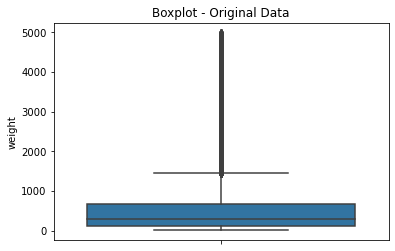

df scaled shape:  (64471, 3)


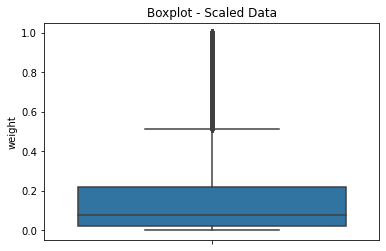

In [13]:
weights_scaled = scale_weight_by_user(weights_for_model)

In [14]:
def train_test_split(df,sample_size,seed=1):
    '''
    Requires input dataframe with userID, artistID, weight columns
    sample_size = number of artists per user to sample for test set
    
    sample_size must be smaller than total artist count per user!!!
    
    '''  
    print('\n')
    print('**Train-Test Split**')
    print(f"input data shape: {df.shape}")
    
    np.random.seed(seed)
    sample = df.groupby('userID').apply(lambda x: x.sample(sample_size))
    sample_index = list(sample.index.get_level_values(1))
 
    train  = df[~df.index.isin(sample_index)]
    train.reset_index(drop=True,inplace=True)
    print(f"train set shape: {train.shape}")

    test  = df[df.index.isin(sample_index)]
    test.reset_index(drop=True,inplace=True)
    print(f"test set shape: {test.shape}")
    print('\n')
    #all test artists must be part of the training data
    unique_train = train['artistID'].unique()
    unique_test = test['artistID'].unique()
    diff = np.setdiff1d(unique_test,unique_train)
    if len(diff)>1:
        print(f"WARNING: {len(diff)} artists from the test set are not on the train set")
        print('1.consider increasing the min count of users per artist when pre-processing')
        print('2.consider decreasing the number of samples per user for train-test split')
        print('3.as al ast resource consider changing your seed')
    else:
        print('OK: all artists from the test set are part on the train set as well')
    return train, test

In [15]:
train, test = train_test_split(weights_scaled,5,2021)



**Train-Test Split**
input data shape: (64471, 3)
train set shape: (55526, 3)
test set shape: (8945, 3)


OK: all artists from the test set are part on the train set as well


In [16]:
print(weights_scaled)

       userID  artistID    weight
0           2        58  1.000000
1           2        59  0.915480
2           2        61  0.790064
3           2        63  0.733111
4           2        64  0.705544
...       ...       ...       ...
64466    2100      2765  0.058223
64467    2100      3806  0.017407
64468    2100      4271  1.000000
64469    2100      4611  0.000000
64470    2100      9783  0.259904

[64471 rows x 3 columns]


## Model training and fitting process. ***Anna's code part 
#### I have used the Surprise package which is speficially designed for recommender algorithms. 

In [17]:
#!pip install scikit-surprise
from surprise import SVD

In [18]:
from surprise import Dataset
from surprise import Reader
#reader range is (0;1) since this is min and max values in column 'Weight' after normalization  
reader = Reader(rating_scale = (0, 1))
data_whole = Dataset.load_from_df(weights_scaled[['userID', 'artistID', 'weight']], reader)
data_train = Dataset.load_from_df(train[['userID', 'artistID', 'weight']], reader)
data_test = Dataset.load_from_df(test[['userID', 'artistID', 'weight']], reader)

In [19]:
# Surprise package requires its own separation of train and test for the further use so I run its own code as well: 
#also the package requires own type of fulldataset format, I run it below as well : 

#approach #1 splitting data into train and test 
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data_whole, test_size=0.2)

#approach #2 using cross validation: 
trainsetfull = data_whole.build_full_trainset()


print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')



Number of users:  1789 

Number of items:  2049 



In [20]:
# KNN model 
from surprise import KNNWithMeans
my_k = 15
my_min_k = 5
my_sim_option = {
    'name':'pearson', 'user_based':False, 
    }
algorithm = KNNWithMeans(
    k = my_k, min_k = my_min_k, sim_option = my_sim_option
    )
algorithm.fit(trainset)

from surprise import accuracy
predictions = algorithm.test(testset)
print(accuracy.rmse(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2338
0.23379675059207172


Cross-Validation approach might be better in this situation since it does a multiple runs of testing the model's performance to see whether the model is overfitting or not. 

In [21]:
# cross valudation method for KNN  
from surprise import SVD
from surprise.model_selection import cross_validate
#algoSVD = SVD()
#algoSVD.fit(trainset)
resultsKNN = cross_validate(
    algo = algorithm, data = data_whole, measures=['RMSE'], 
    cv=5, return_train_measures=True
    )
print(resultsKNN['test_rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
[0.23910663 0.23897583 0.23607689 0.23702329 0.23004188]


In [22]:
resultsKNN['test_rmse'].mean()

0.23624490366943718

In [23]:
# cross valudation method for SVD 
from surprise import SVD
algoSVD = SVD()
algoSVD.fit(trainset)
resultsSVD = cross_validate(
    algo = algoSVD, data = data_whole, measures=['RMSE'], 
    cv=5, return_train_measures=True
    )
print(resultsSVD['test_rmse'])

[0.24071756 0.23943238 0.23894158 0.2434477  0.23714847]


In [24]:
resultsSVD['test_rmse'].mean()

0.2399375387078308

In [25]:
# cross valudation method for Non-negative Matrix Factorization (NMF) 
from surprise import NMF
algoNMF = NMF()
algoNMF.fit(trainset)
resultsNMF = cross_validate(
    algo = algoNMF, data = data_whole, measures=['RMSE'], 
    cv=5, return_train_measures=True
    )
print(resultsNMF['test_rmse'])

[0.23925079 0.23358866 0.23548611 0.2361335  0.24211313]


In [26]:
resultsNMF['test_rmse'].mean()

0.2373144383508962

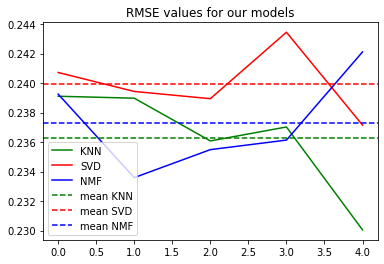

In [27]:
KNN = resultsKNN['test_rmse']
SVD = resultsSVD['test_rmse']
NMF = resultsNMF['test_rmse']
plt.plot(KNN, color='g', label='KNN')
plt.plot(SVD, color='r', label='SVD')
plt.plot(NMF, color='b', label='NMF')
K = resultsKNN['test_rmse'].mean()
S = resultsSVD['test_rmse'].mean()
N = resultsNMF['test_rmse'].mean()

plt.axhline(K, color='g', linestyle='--', label='mean KNN')
plt.axhline(S, color='r', linestyle='--', label='mean SVD')
plt.axhline(N, color='b', linestyle='--', label='mean NMF')


plt.title("RMSE values for our models")
plt.legend()
plt.show()

The lower RMSE is - the more accurate the recommendation engine predicts. This metrics is good to use when the recommendations are based on the predicting rating or number of transactions (in our case it is weights) . It gives us the sense of accuracy of our prediction ratings.

Now it is time to train the algorithm on the whole dataset we have. It is required as we can not do predictions from cross-validation results itself. 

In [28]:
algorithm.fit(trainsetfull)

Computing the msd similarity matrix...
Done computing similarity matrix.


The Suprrise package handles datasets a bit differently so we can only fit the model on the whole dataset, can not split it into train and test. 
Now we are moving into prediction part. Predictions with Surprise package can only be made for users who are already in the dataset. That's why it also makes sence to train the model on the whole dataset. 
in order to do predictions for specific users, we will need to know userID from the dataset we have, and we also need to pick the artist's ID for that specific user, since the algorithm will recommend the similar artists based on that information. 
It is logical to use the specific artist per user for the prediction since one user can listen to very different rance of genres and our purpose is to advice him a few artists based on one genre chosen. For example, if user is now listening to Rock style artist, the recommendation for the next 5 or 10 artists will be based on that genre. 

Picking userID and artistID from Weights_scaled dataframe :

In [29]:
print(algorithm.predict(uid = 2100, iid = 2765))
print(algorithm.predict(uid = 2, iid = 58))

print(algorithm.predict(uid = 2100, iid = 9783))
print(algorithm.predict(uid = 2, iid = 9783))
print(algorithm.predict(uid = 2100, iid = 4611))
print(algorithm.predict(uid = 2, iid = 4611))

user: 2100       item: 2765       r_ui = None   est = 0.22   {'actual_k': 11, 'was_impossible': False}
user: 2          item: 58         r_ui = None   est = 0.60   {'actual_k': 15, 'was_impossible': False}
user: 2100       item: 9783       r_ui = None   est = 0.14   {'actual_k': 8, 'was_impossible': False}
user: 2          item: 9783       r_ui = None   est = 0.15   {'actual_k': 5, 'was_impossible': False}
user: 2100       item: 4611       r_ui = None   est = 0.20   {'actual_k': 8, 'was_impossible': False}
user: 2          item: 4611       r_ui = None   est = 0.32   {'actual_k': 1, 'was_impossible': False}


In [30]:
# https://surprise.readthedocs.io/en/stable/FAQ.html

from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [31]:
# First train an KNN algorithm on the  dataset.

trainsetKNN = data_whole.build_full_trainset()
#algo = SVD()
algorithm.fit(trainsetKNN)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testsetKNN = trainsetKNN.build_anti_testset()
predictions = algorithm.test(testsetKNN)

top_n = get_top_n(predictions, n=5)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

Computing the msd similarity matrix...
Done computing similarity matrix.
2 [6600, 51, 3183, 3264, 1113]
4 [2944, 3341, 8459, 2086, 758]
5 [51, 3264, 289, 2026, 5267]
6 [72, 3832, 1206, 1755, 1627]
7 [3264, 6618, 3832, 233, 7260]
8 [3264, 748, 6618, 1197, 6600]
9 [289, 1504, 1994, 2044, 3046]
10 [72, 758, 793, 3264, 744]
11 [2702, 631, 190, 6724, 758]
12 [2572, 173, 6618, 1994, 3264]
13 [72, 3264, 3832, 416, 758]
14 [1121, 195, 2624, 1946, 227]
15 [1975, 6150, 5267, 2026, 72]
16 [748, 3264, 2101, 3046, 289]
17 [2026, 72, 2838, 51, 1975]
18 [2026, 2101, 758, 5089, 5267]
20 [3754, 2101, 1975, 3264, 51]
21 [227, 748, 3832, 173, 8]
22 [3754, 173, 289, 5079, 2572]
23 [5267, 3227, 744, 51, 173]
24 [3832, 758, 233, 1975, 6724]
25 [6618, 1975, 3832, 1094, 748]
26 [5267, 758, 289, 6724, 152]
27 [2026, 1994, 3832, 2944, 758]
28 [7260, 3183, 3264, 6724, 173]
29 [758, 227, 72, 748, 3832]
30 [72, 51, 3832, 917, 3183]
31 [918, 6150, 758, 6724, 2026]
32 [51, 152, 367, 2026, 2086]
33 [2026, 758, 1718, 

941 [3264, 3183, 758, 2838, 152]
943 [289, 1994, 2702, 2026, 72]
946 [758, 2572, 367, 3754, 748]
948 [758, 744, 1946, 6762, 2478]
949 [203, 227, 89, 1047, 618]
950 [51, 758, 3183, 2471, 1726]
951 [3264, 285, 758, 744, 1994]
952 [72, 3183, 1975, 6724, 375]
953 [3183, 3264, 758, 195, 416]
954 [227, 846, 631, 6724, 748]
955 [51, 3264, 758, 2086, 4123]
957 [289, 2531, 4566, 470, 503]
958 [5089, 758, 51, 3737, 3227]
959 [5089, 3028, 6150, 3183, 1726]
960 [758, 51, 3264, 3183, 1726]
961 [744, 289, 72, 758, 233]
962 [3754, 289, 918, 3264, 424]
963 [1975, 3264, 51, 2442, 748]
964 [1946, 72, 1994, 1726, 289]
965 [6618, 748, 1975, 3264, 6600]
966 [72, 6618, 3028, 1944, 3264]
967 [3264, 2086, 4123, 2101, 8459]
968 [72, 2086, 289, 2026, 6906]
969 [1946, 72, 5089, 418, 1994]
971 [3264, 1944, 72, 4123, 2101]
972 [1718, 758, 744, 308, 152]
975 [72, 5089, 6618, 3264, 3832]
976 [1694, 2026, 72, 679, 758]
977 [758, 51, 3183, 3264, 816]
978 [758, 72, 4123, 8459, 1726]
979 [72, 1994, 748, 6618, 2026]
981 

1243 [89, 285, 2702, 816, 3264]
1244 [89, 6150, 2026, 289, 3264]
1245 [51, 72, 289, 2572, 1964]
1246 [6724, 1094, 5423, 3264, 617]
1247 [758, 1944, 1975, 3832, 3417]
1248 [5089, 197, 72, 758, 51]
1249 [173, 758, 2026, 744, 3227]
1253 [3264, 3028, 6618, 227, 51]
1254 [72, 758, 1975, 744, 8707]
1255 [51, 2026, 744, 152, 6150]
1256 [3264, 154, 2086, 2101, 1975]
1258 [2026, 1975, 3264, 679, 4123]
1259 [72, 197, 2572, 3046, 1994]
1261 [3264, 289, 1910, 3132, 2101]
1263 [1975, 72, 6618, 1094, 748]
1264 [89, 2101, 758, 197, 2086]
1265 [2026, 1975, 758, 3341, 2086]
1267 [72, 744, 2702, 2026, 1994]
1270 [3264, 375, 6618, 8459, 173]
1271 [72, 152, 356, 2442, 7525]
1272 [72, 758, 3264, 1946, 173]
1273 [51, 744, 2026, 152, 6150]
1274 [72, 1994, 173, 705, 289]
1275 [288, 89, 758, 1964, 1975]
1276 [6724, 3264, 51, 506, 1944]
1277 [3832, 1994, 2101, 289, 3264]
1278 [3264, 2775, 748, 72, 3832]
1279 [233, 51, 3264, 3832, 744]
1280 [3264, 6150, 51, 758, 5089]
1281 [3754, 8707, 51, 2944, 89]
1282 [344, 1

1844 [2026, 72, 3264, 744, 152]
1845 [2026, 1994, 72, 416, 705]
1846 [3264, 918, 1944, 1964, 7525]
1850 [3832, 3264, 3183, 1944, 152]
1851 [877, 5089, 6618, 8, 72]
1852 [72, 1946, 748, 51, 5089]
1853 [758, 2026, 744, 72, 906]
1855 [1975, 152, 1718, 758, 2702]
1856 [72, 2775, 3183, 576, 6724]
1857 [72, 758, 6762, 744, 2838]
1858 [4123, 758, 2944, 3227, 3264]
1860 [2580, 72, 154, 152, 880]
1861 [3264, 1994, 6724, 3769, 1944]
1862 [72, 744, 758, 292, 2026]
1863 [748, 758, 877, 3832, 5089]
1864 [2580, 5267, 292, 51, 163]
1865 [3264, 758, 57, 285, 744]
1866 [6618, 1946, 344, 152, 72]
1868 [72, 6600, 1994, 289, 1433]
1869 [758, 3264, 2775, 6618, 5089]
1871 [72, 5089, 3832, 1944, 576]
1872 [72, 758, 1094, 197, 416]
1873 [1944, 758, 227, 4123, 3832]
1874 [2580, 1121, 72, 1979, 227]
1875 [51, 3264, 2026, 744, 1837]
1877 [2086, 2026, 3264, 1994, 5089]
1879 [51, 2944, 618, 288, 2236]
1880 [705, 72, 1994, 5089, 416]
1881 [3183, 2667, 3264, 6618, 6724]
1883 [2026, 51, 289, 227, 6906]
1885 [758, 72,

In [32]:
W = []

for uid, user_ratings in top_n.items():
    for iid, _ in user_ratings:
        W.append(iid)
#print(Z)
from collections import Counter

WL = Counter(W).keys()
WK = Counter(W).values()
print(len(list(zip(WL, WK))))

    #print(user_ratings)
    #print(uid, [iid for (iid, _) in user_ratings]

292


Picking one of the users in the list above and checking the prediction by pulling out the actual artists names and genres: 
2090 [758, 2667, 2026, 1837, 744]
2091 [758, 375, 503, 289, 2026]

In [33]:
testuser1_data = weights_scaled[weights_scaled['userID']==2090]

print(testuser1_data)

       userID  artistID    weight
64205    2090       233  0.218947
64206    2090       234  0.058947
64207    2090       370  1.000000
64208    2090       441  0.248421
64209    2090       450  0.429474
64210    2090       707  0.941053
64211    2090       858  0.368421
64212    2090       868  0.677895
64213    2090       875  0.246316
64214    2090       881  0.328421
64215    2090      1099  0.528421
64216    2090      1202  0.345263
64217    2090      1231  0.058947
64218    2090      1534  0.202105
64219    2090      1888  0.781053
64220    2090      2369  0.850526
64221    2090      2381  0.113684
64222    2090      2471  0.343158
64223    2090      3333  0.166316
64224    2090      8555  0.029474
64225    2090      9783  0.000000
64226    2090     11754  0.650526


In [34]:
testuser2_data = weights_scaled[weights_scaled['userID']==2091]

print(testuser2_data)

       userID  artistID    weight
64227    2091        56  0.166667
64228    2091        81  0.599099
64229    2091       330  0.238739
64230    2091       468  0.058559
64231    2091       972  0.202703
64232    2091      1401  0.126126
64233    2091      1433  0.427928
64234    2091      1449  0.117117
64235    2091      1457  0.031532
64236    2091      2222  0.153153
64237    2091      2236  0.090090
64238    2091      3670  0.076577
64239    2091      4316  1.000000
64240    2091      4344  0.193694
64241    2091      4586  0.265766
64242    2091      5119  0.000000
64243    2091      6626  0.252252


In [35]:
#pulling genres of srtists which those users have already listened to: 
artists = artist_df[['id', 'name']]

for a in testuser1_data['artistID']:
    print(artists[artists['id'] == a])

      id             name
227  233  Nine Inch Nails
      id     name
228  234  Nirvana
      id       name
364  370  Katatonia
      id          name
435  441  Joy Division
      id               name
444  450  She Wants Revenge
      id       name
701  707  Metallica
      id       name
849  858  PJ Harvey
      id       name
859  868  The Doors
      id     name
866  875  Bauhaus
      id   name
872  881  Kyuss
        id         name
1090  1099  The Prodigy
        id     name
1193  1202  Melvins
        id               name
1222  1231  The Dresden Dolls
        id                  name
1525  1534  The Sisters of Mercy
        id  name
1879  1888  Wire
        id             name
2354  2369  Type O Negative
        id      name
2366  2381  Dethklok
        id        name
2456  2471  Current 93
        id            name
3296  3333  The Distillers
        id         name
8354  8555  Pat Benatar
        id                               name
9548  9783  The Kilimanjaro Darkjazz Ensem

In [36]:
for a in testuser2_data['artistID']:
    print(artists[artists['id'] == a])

    id       name
50  56  Daft Punk
    id        name
75  81  Portishead
      id  name
324  330  T.I.
      id   name
462  468  Usher
      id      name
963  972  t.A.T.u.
        id      name
1392  1401  deadmau5
        id          name
1424  1433  Daddy Yankee
        id     name
1440  1449  Pitbull
        id     name
1448  1457  Cherish
        id                  name
2207  2222  Bone Thugs-N-Harmony
        id      name
2221  2236  Ice Cube
        id       name
3598  3670  Matisyahu
        id    name
4232  4316  Tricky
        id           name
4260  4344  Damian Marley
        id name
4492  4586  RZA
        id        name
5000  5119  Marcelo D2
        id name
6484  6626  DMX


In [37]:
#2090 [758, 2667, 2026, 1837, 744]
print(artists[artists['id'] == 758])
print(artists[artists['id'] == 2667])
print(artists[artists['id'] == 2026])
print(artists[artists['id'] == 1837])
print(artists[artists['id'] == 744])

      id    name
749  758  Психея
        id           name
2647  2667  The Flashbulb
        id           name
2011  2026  The Residents
        id          name
1828  1837  Scott Walker
      id      name
735  744  Autechre


In [38]:
directory = os.getcwd()
data_path = os.path.join(directory, "data")
#print(data_path)
artcsv = os.path.join(data_path, "artists.csv")
art = pd.read_csv(artcsv)
print("artist_sp_df shape: ",art.shape)

artist_sp_df shape:  (1104349, 5)


In [39]:
art_f = art[['genres', 'name']]
art_f

,genres,name
0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani
1,[],ปูนา ภาวิณี
2,[],Sadaa
3,[],Tra'gruda
4,[],Ioannis Panoutsopoulos
...,...,...
1104344,[],Cody Longo
1104345,['deep acoustic pop'],Right the Stars
1104346,[],Jesse Giddings
1104347,[],The Boy Band Project


###### testuser 1 listened to these artist and genres: 

In [40]:
print (art_f[art_f['name'] ==  'Nine Inch Nails' ])
print (art_f[art_f['name'] ==  'Nirvana' ])
print (art_f[art_f['name'] ==  'Katatonia' ])
print (art_f[art_f['name'] ==  'Joy Division' ])
print (art_f[art_f['name'] ==  'She Wants Revenge' ])
print (art_f[art_f['name'] ==  'Metallica' ])
print (art_f[art_f['name'] ==  'PJ Harvey' ])
print (art_f[art_f['name'] ==  'The Doors' ])
print (art_f[art_f['name'] ==  'Bauhaus' ])
print (art_f[art_f['name'] ==  'Kyuss' ])


                                                   genres             name
145581  ['alternative metal', 'alternative rock', 'cyb...  Nine Inch Nails
                                                   genres     name
94464                                                  []  Nirvana
141876  ['alternative rock', 'grunge', 'permanent wave...  Nirvana
                                                  genres       name
95331  ['alternative metal', 'doom metal', 'gothic me...  Katatonia
                                                   genres          name
144867  ['alternative rock', 'art rock', 'madchester',...  Joy Division
                                                  genres               name
121674  ['alternative dance', 'dance-punk', 'dark wave']  She Wants Revenge
                                                   genres       name
142075  ['hard rock', 'metal', 'old school thrash', 'r...  Metallica
                                                   genres       name
142535  ['

#### testuser1 has received these top 5 recommendations: 

In [41]:
print (art_f[art_f['name'] ==  'Психея' ])# this group has no genres data,it is 'digital hardcore', 'alternative metal'
print (art_f[art_f['name'] ==  'The Flashbulb' ])
print (art_f[art_f['name'] ==  'The Residents' ])
print (art_f[art_f['name'] ==  'Scott Walker' ])
print (art_f[art_f['name'] ==  'Autechre' ])

Empty DataFrame
Columns: [genres, name]
Index: []
                                                   genres           name
894117  ['breakcore', 'drill and bass', 'intelligent d...  The Flashbulb
                                                  genres           name
94816  ['art rock', 'experimental', 'experimental roc...  The Residents
                                                   genres          name
139653  ['art pop', 'art rock', 'baroque pop', 'brill ...  Scott Walker
603833                                                 []  Scott Walker
                                                  genres      name
95422  ['abstract', 'ambient', 'ambient techno', 'dri...  Autechre


#### Recommendations for user2: 2091 [758, 375, 503, 289, 2026]

In [42]:
print(artists[artists['id'] == 758])
print(artists[artists['id'] == 375])
print(artists[artists['id'] == 503])
print(artists[artists['id'] == 289])
print(artists[artists['id'] == 2026])

      id    name
749  758  Психея
      id   name
369  375  浜崎あゆみ
      id       name
497  503  In Flames
      id            name
283  289  Britney Spears
        id           name
2011  2026  The Residents


###### testuser 2 listened to these artist and genres: 

In [43]:
print (art_f[art_f['name'] ==  'Daft Punk' ])
print (art_f[art_f['name'] ==  'Portishead' ])
print (art_f[art_f['name'] ==  'T.I.' ])
print (art_f[art_f['name'] ==  'Usher' ])
print (art_f[art_f['name'] ==  't.A.T.u.' ])
print (art_f[art_f['name'] ==  'deadmau5' ])
print (art_f[art_f['name'] ==  'Daddy Yankee' ])
print (art_f[art_f['name'] ==  'Pitbull' ])
print (art_f[art_f['name'] ==  'Cherish' ])
print (art_f[art_f['name'] ==  'Bone Thugs-N-Harmony' ]) #genre 'hip-hop', 'rap'

                             genres       name
144514  ['electro', 'filter house']  Daft Punk
                                            genres        name
142360  ['electronica', 'laboratorio', 'trip hop']  Portishead
                                                   genres  name
145931  ['atl hip hop', 'dance pop', 'dirty south rap'...  T.I.
                                                   genres   name
143820  ['atl hip hop', 'dance pop', 'pop', 'r&b', 'so...  Usher
                             genres      name
143678  ['dance pop', 'girl group']  t.A.T.u.
                                                   genres      name
143271  ['canadian electronic', 'edm', 'electro house'...  deadmau5
                                                   genres          name
142829  ['latin', 'latin hip hop', 'reggaeton', 'trap ...  Daddy Yankee
                                                   genres     name
143252  ['dance pop', 'latin', 'miami hip hop', 'pop',...  Pitbull
                

#### testuser2 has received these top 5 recommendations: 

In [44]:
print (art_f[art_f['name'] ==  'Психея' ]) # this group has no genres data,it is 'digital hardcore', 'alternative metal'
print (art_f[art_f['name'] ==  '浜崎あゆみ' ]) #Ayumi Hamasaki, 'rock', 'pop', 'electronic dance music'
print (art_f[art_f['name'] ==  'In Flames' ])
print (art_f[art_f['name'] ==  'Britney Spears' ])
print (art_f[art_f['name'] ==  'The Residents' ])

Empty DataFrame
Columns: [genres, name]
Index: []
Empty DataFrame
Columns: [genres, name]
Index: []
                                                   genres       name
144801  ['alternative metal', 'gothenburg metal', 'mel...  In Flames
                                                  genres            name
143817  ['dance pop', 'pop', 'pop rap', 'post-teen pop']  Britney Spears
                                                  genres           name
94816  ['art rock', 'experimental', 'experimental roc...  The Residents


# KNN model evaluation metrics 

In [45]:
#precision and recall 
from collections import defaultdict

from surprise import Dataset
from surprise.model_selection import KFold


def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


In [46]:
kf = KFold(n_splits=5)
prec = []
rec = []
for trainset, testset in kf.split(data_whole):
    algorithm.fit(trainset)
    predictions = algorithm.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=0.3)

    # Precision and recall can then be averaged over all users
    prec.append(sum(prec for prec in precisions.values()) / len(precisions))
    rec.append(sum(rec for rec in recalls.values()) / len(recalls))
    
    
print(prec)
print(rec)
    
   # print(sum(prec for prec in precisions.values()) / len(precisions))
  #  print(sum(rec for rec in recalls.values()) / len(recalls))
    
   # plt.plot(precisions.values(), color='g', label='precision')
#plt.plot(recalls.values(), color='r', label='recall')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
[0.13843060231949128, 0.13861126707842036, 0.14519932622122406, 0.14683698296836986, 0.1432717431877567]
[0.13670434503767845, 0.12643066584672427, 0.13288704401843088, 0.13696558915537024, 0.137986144439112]


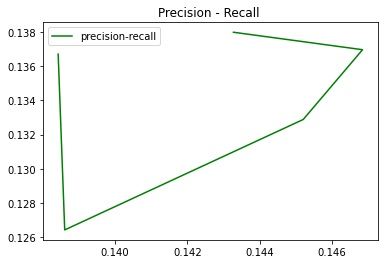

In [47]:
plt.plot(prec,rec, color='g', label='precision-recall')
#plt.plot(rec, color='r', label='recall')

#plt.axhline(0.2, color='b', linestyle='--', label='threshold')



plt.title("Precision - Recall ")
plt.legend()
plt.show()

Note: I am not sure which threshold to choose for precision-recall. 
Precision - Recall is the Desicion support accuracy metrics. It helps to select artists that are more similar among the available set of artists for that specific user. They are the go-to metrics used for recommendation systems. 

While creating a recommendation system it is important NOT to optimize only by a simgle metric and it is NOT advisable to get a very high recall number, because this will mean that we are recommending the users artists that they would have naturally listened to without our recommendation. Decent Precision - recall metric may show us that our model is able to learn from users' preferences, and not only try to maximize  it. it is important for us to keep the user engaged with the new artists discovery and not to get bored from the recommendations of artists that they would know even without our recommendation system or even worse, whom they have got recommended over and over again - and it may happen if we will try to maximize Precision - recall metrics. . 

In [48]:
print(len(list(zip(WL, WK))))

292


only 292 artists have been sued in the recommender. 

In [49]:
print(weights_scaled['artistID'].nunique())

2049


the total number of artists is 2049, but the model has used only 14% of it (292) for recommendation. It proves that it is biased towards the more popular artists with higher weights. 
It is normal that the model has not used all the artist available since we pick only 20% of the data for testing, but it could recommend higher number of differnet artist with bias being less. 

In [50]:
print(WL)
print(sum(WK))
print(WK)
print(789/sum(WK))

#print((list(zip(WL, WK))))

dict_keys([6600, 51, 3183, 3264, 1113, 2944, 3341, 8459, 2086, 758, 289, 2026, 5267, 72, 3832, 1206, 1755, 1627, 6618, 233, 7260, 748, 1197, 1504, 1994, 2044, 3046, 793, 744, 2702, 631, 190, 6724, 2572, 173, 416, 1121, 195, 2624, 1946, 227, 1975, 6150, 2101, 2838, 5089, 3754, 8, 5079, 3227, 1094, 152, 917, 918, 367, 1718, 197, 89, 1433, 816, 458, 1048, 1726, 4821, 154, 182, 1401, 1981, 2094, 344, 877, 4123, 479, 439, 2442, 1694, 2775, 1944, 1837, 906, 6906, 615, 1001, 1659, 497, 1672, 1097, 1853, 487, 2478, 1339, 1047, 707, 6762, 3774, 1868, 811, 292, 375, 1854, 1964, 498, 618, 217, 207, 3032, 3732, 2580, 1547, 39, 470, 4616, 356, 467, 285, 679, 4316, 4136, 3132, 57, 222, 3028, 705, 2419, 2531, 461, 55, 506, 1412, 1372, 2840, 522, 45, 3892, 599, 455, 370, 2471, 3616, 424, 486, 3737, 1510, 423, 7525, 5630, 3200, 4074, 6159, 1904, 7054, 2390, 288, 408, 2214, 1943, 1396, 1098, 814, 440, 1109, 418, 504, 2139, 792, 2667, 3237, 67, 2424, 4828, 1910, 932, 747, 8707, 2794, 1360, 1110, 3333, 48

We can see that artist ID 72 has been recommended 789 times, which is aprox. 9% from the whole list of recimmended artists. 

In [51]:
print(artists[artists['id'] == 72])
print(artists[artists['id'] == 3264])
print(artists[artists['id'] == 51])

    id          name
66  72  Depeche Mode
        id       name
3227  3264  Marillion
    id         name
45  51  Duran Duran


In [52]:
print(artists[artists['id'] == 29])
print(artists[artists['id'] == 578])
print(artists[artists['id'] == 899])
print(artists[artists['id'] == 1461])
print(artists[artists['id'] == 1476])

Empty DataFrame
Columns: [id, name]
Index: []
      id         name
572  578  James Brown
      id           name
890  899  Missy Higgins
        id           name
1452  1461  Big Time Rush
        id           name
1467  1476  Based On Abba


In [55]:
testuser3_data = weights_scaled[weights_scaled['userID']==1363]
print(testuser3_data)

       userID  artistID    weight
42062    1363       159  0.057358
42063    1363       173  0.099144
42064    1363       209  0.081235
42065    1363       210  0.005450
42066    1363       324  0.237477
42067    1363       333  0.169219
42068    1363       412  0.215936
42069    1363       466  0.112899
42070    1363       486  0.089281
42071    1363       492  0.187386
42072    1363       498  1.000000
42073    1363       518  0.390345
42074    1363       536  0.111601
42075    1363       537  0.604464
42076    1363       540  0.133403
42077    1363       548  0.043083
42078    1363       687  0.759668
42079    1363       691  0.169997
42080    1363       693  0.086945
42081    1363       703  0.081495
42082    1363       779  0.019725
42083    1363       816  0.107189
42084    1363       936  0.001817
42085    1363       968  0.082014
42086    1363      1035  0.062808
42087    1363      1040  0.342331
42088    1363      1047  0.000000
42089    1363      1091  0.155463
42090    1363 

In [56]:
for a in testuser3_data['artistID']:
    print(artists[artists['id'] == a])

      id      name
153  159  The Cure
      id     name
167  173  Placebo
      id                 name
203  209  My Chemical Romance
      id        name
204  210  Bloc Party
      id            name
318  324  Cobra Starship
      id           name
327  333  Avril Lavigne
      id       name
406  412  blink-182
      id   name
460  466  Ke$ha
      id                name
480  486  30 Seconds to Mars
      id                  name
486  492  Funeral for a Friend
      id      name
492  498  Paramore
      id               name
512  518  Within Temptation
      id            name
530  536  Good Charlotte
      id      name
531  537  The Used
      id          name
534  540  Fall Out Boy
      id            name
542  548  Ellie Goulding
      id          name
681  687  All Time Low
      id      name
685  691  Owl City
      id        name
687  693  Hey Monday
      id    name
697  703  The xx
      id                  name
770  779  Bring Me The Horizon
      id               name
807  8